In [1]:
#导入项目中所需相关算子库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from matplotlib import rc

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_stata("Machine_Learning_Data_all_country.dta")

# 根据county_id筛选数据
dtrain = data[data["country"] == 4]

# 查看训练集和测试集大小
print("训练集大小：", np.shape(dtrain))


训练集大小： (20539, 47)


In [3]:
# 查看数据缺失情况
print('缺失值统计：')
print(dtrain.apply(lambda x: sum(x.isnull())))

缺失值统计：
comp_id             0
year                0
revenue          1044
total_assets        0
r_and_d          1046
ebitda           1044
st_invest        1034
cash             1034
TPos                0
srad                0
pr                  0
vap                 0
vs                  0
TNeg                0
PPos                0
PNeg                0
net_income          0
op_exp              0
curr_assets         0
curr_liab           0
lt_investment       0
lt_debt             0
st_debt             0
cash_acq            0
common_rep          0
pref_rep            0
emp_count           0
mkt_cap             0
fcf              2216
div_total        1782
net_assets          0
leverage            0
market_val       1034
sic                 0
country_short       0
GDP                 0
GDP_pc              0
GDP_growth          0
inflation           0
inst_own            0
public_own          0
country             0
L_TPos           1472
L_TNeg           1472
L_PPos           1472
L_P

In [4]:
# 删除包含缺失值的行
dtrain = dtrain.dropna()

# 再次查看数据缺失情况
print('缺失值统计：')
print(dtrain.apply(lambda x: sum(x.isnull())))

缺失值统计：
comp_id          0
year             0
revenue          0
total_assets     0
r_and_d          0
ebitda           0
st_invest        0
cash             0
TPos             0
srad             0
pr               0
vap              0
vs               0
TNeg             0
PPos             0
PNeg             0
net_income       0
op_exp           0
curr_assets      0
curr_liab        0
lt_investment    0
lt_debt          0
st_debt          0
cash_acq         0
common_rep       0
pref_rep         0
emp_count        0
mkt_cap          0
fcf              0
div_total        0
net_assets       0
leverage         0
market_val       0
sic              0
country_short    0
GDP              0
GDP_pc           0
GDP_growth       0
inflation        0
inst_own         0
public_own       0
country          0
L_TPos           0
L_TNeg           0
L_PPos           0
L_PNeg           0
tem              0
dtype: int64


In [5]:
#修剪
#import numpy as np
#import pandas as pd

#def winsorize_data(data):
    #exclude_columns = ['comp_id', 'year', 'tmax_pos', 'tmin_neg', 'pr_pos', 'pr_neg',
                            #'pr_norm', 'tm_norm', 'srad', 'vap', 'vs', 'country']
    # 获取需要处理的列，排除掉指定的列
    #columns_to_process = [col for col in data.columns if col not in exclude_columns]
    # 记录需要删除的行的索引
    #rows_to_delete = pd.Series(False, index=data.index)
    #for col in columns_to_process:
        #lower_percentile = np.percentile(data[col], 1)
        #upper_percentile = np.percentile(data[col], 99)
        # 找到超出1%和99%分位数的异常值
        #outliers = (data[col] < lower_percentile) | (data[col] > upper_percentile)
        # 将异常值的行标记为True
        #rows_to_delete = rows_to_delete | outliers
     # 删除标记为True的行
    #data = data[~rows_to_delete]
    #return data


In [6]:
import numpy as np
import pandas as pd

def winsorize_data(data):
    exclude_columns = ['comp_id', 'year', 'sic', 'country', 'country_short']
    columns_to_process = [col for col in data.columns if col not in exclude_columns]
    for col in columns_to_process:
        lower_percentile = np.percentile(data[col], 1)
        upper_percentile = np.percentile(data[col], 99)
        data[col] = np.clip(data[col], lower_percentile, upper_percentile)
    return data

In [7]:
dtrain = winsorize_data(dtrain)

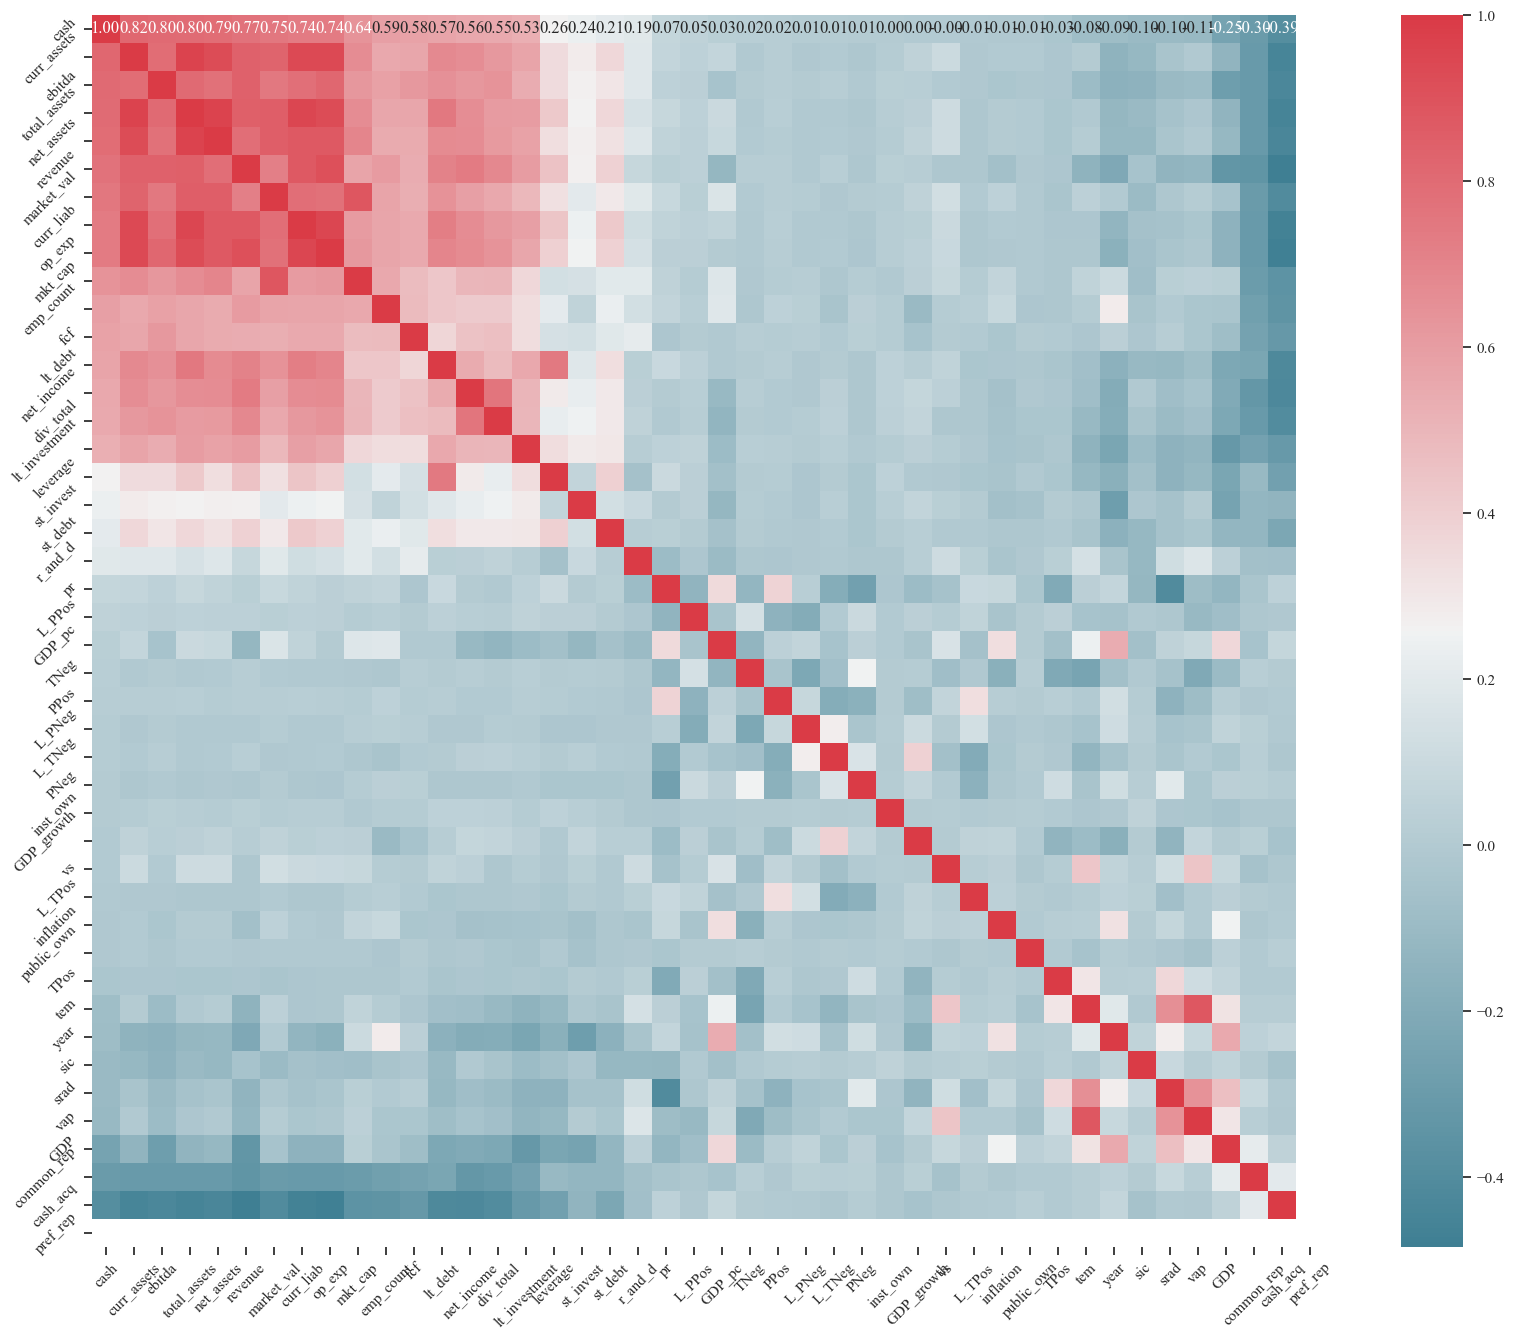

In [9]:
# 绘制热图函数
# 设置全局字体为Times New Roman
rc('font', family='Times New Roman')
def heatmap(df):
    # 排除不需要的变量
    df_filtered = df.drop(columns=['comp_id', 'country', 'country_short'])
    
    # 计算Spearman相关系数
    mcorr = df_filtered.corr(method = 'spearman')
    
    # 根据与 'CASH_EQV' 的相关系数排序
    cash_corr = mcorr['cash'].sort_values(ascending=False)
    
    # 提取排序后的数据，确保与CASH_EQV相关性最大的变量排在前面
    df_sorted = df_filtered[cash_corr.index]
    
    # 设置热图
    plt.figure(figsize=(20, 16), dpi=100)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 设置颜色映射
    # 暂时去掉mask，以确保显示相关系数值
    g = sns.heatmap(df_sorted.corr(method='spearman'), cmap=cmap, square=True, annot=True, fmt='.2f',
                    annot_kws={'size': 12, 'ha': 'center', 'va': 'center'})
    
    # 旋转x轴和y轴标签
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # 保存热图为400 dpi的图片
    plt.savefig('heatmap_correlation_NorthernEurope.png', dpi=400, bbox_inches='tight')

    return cash_corr

# 使用修改后的heatmap函数
dtrain_mcorr = heatmap(dtrain)


In [8]:
from sklearn.preprocessing import StandardScaler #特征标准化
# 提取特征和目标变量
X = dtrain.drop(columns=['comp_id', 'country', 'country_short', 'cash'])
y = dtrain['cash']

# 获取特征名称列表
feature_names = X.columns.tolist()
print("特征名称列表:")
print(feature_names)

#标准化前的变量描述性统计
import pandas as pd
X_train_df = pd.DataFrame(X)
print(X_train_df.describe())
y_train_series = pd.Series(y)
print(y_train_series.describe())

特征名称列表:
['year', 'revenue', 'total_assets', 'r_and_d', 'ebitda', 'st_invest', 'TPos', 'srad', 'pr', 'vap', 'vs', 'TNeg', 'PPos', 'PNeg', 'net_income', 'op_exp', 'curr_assets', 'curr_liab', 'lt_investment', 'lt_debt', 'st_debt', 'cash_acq', 'common_rep', 'pref_rep', 'emp_count', 'mkt_cap', 'fcf', 'div_total', 'net_assets', 'leverage', 'market_val', 'sic', 'GDP', 'GDP_pc', 'GDP_growth', 'inflation', 'inst_own', 'public_own', 'L_TPos', 'L_TNeg', 'L_PPos', 'L_PNeg', 'tem']
               year       revenue   total_assets       r_and_d        ebitda  \
count  16744.000000  16744.000000   16744.000000  16744.000000  16744.000000   
mean    2013.983516    968.083956    7155.561960      8.310297    140.018249   
std        7.386690   2770.607329   22324.112362     43.074204    442.311077   
min     1991.000000      0.000000       3.603350      0.000000      0.000000   
25%     2009.000000      5.027500      65.795500      0.000000      1.650000   
50%     2016.000000     59.400000     359.9105

In [9]:
#标准化特征变量
#sc = StandardScaler()
#sc.fit(X)
#X = sc.transform(X)

In [9]:
# 将X和y转换为numpy数组
X = np.array(X)
y = np.array(y)
# 使用train_test_split进行随机划分
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=66)

In [10]:
#查看训练数据描述性统计
import pandas as pd
X_train_df = pd.DataFrame(X_train)
print(X_train_df.describe())
y_train_series = pd.Series(y_train)
print(y_train_series.describe())

                 0             1              2             3             4   \
count  13395.000000  13395.000000   13395.000000  13395.000000  13395.000000   
mean    2013.956327    975.483046    7155.494833      8.259055    140.941647   
std        7.403510   2788.523222   22298.896236     42.875240    445.170079   
min     1991.000000      0.000000       3.603350      0.000000      0.000000   
25%     2009.000000      5.055000      65.779000      0.000000      1.660000   
50%     2016.000000     60.500000     361.416970      0.000000      8.140000   
75%     2020.000000    449.100000    2538.047500      0.000000     55.250000   
max     2023.000000  17931.742000  155375.960000    355.070000   3112.859000   

                 5             6             7             8             9   \
count  13395.000000  13395.000000  13395.000000  13395.000000  13395.000000   
mean      15.879616      3.052930    116.675314     68.760621      0.924762   
std       86.375296      1.706374     23.4

In [11]:
#查看验证数据描述性统计
import pandas as pd
X_valid_df = pd.DataFrame(X_valid)
print(X_valid_df.describe())
y_valid_series = pd.Series(y_valid)
print(y_valid_series.describe())

                0             1              2            3            4   \
count  3349.000000   3349.000000    3349.000000  3349.000000  3349.000000   
mean   2014.092266    938.489803    7155.830448     8.515250   136.324934   
std       7.319115   2697.965161   22428.027048    43.866871   430.731600   
min    1992.000000      0.000000       3.603350     0.000000     0.000000   
25%    2009.000000      4.910000      65.844000     0.000000     1.630000   
50%    2016.000000     54.800000     355.157000     0.000000     7.670000   
75%    2020.000000    463.800000    2777.138000     0.000000    54.800000   
max    2023.000000  17931.742000  155375.960000   355.070000  3112.859000   

                5            6            7            8            9   ...  \
count  3349.000000  3349.000000  3349.000000  3349.000000  3349.000000  ...   
mean     15.786823     3.041505   117.160161    68.939300     0.928996  ...   
std      86.626089     1.671251    24.778470    38.565518     0.29795

In [12]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(n_estimators=2000, max_features=0.6, random_state=0, n_jobs=-1)

# 使用训练数据拟合模型
rf_model.fit(X_train, y_train)

# 使用训练好的模型进行预测
pred_rf_train = rf_model.predict(X_train)  # 样本内预测
pred_rf_valid = rf_model.predict(X_valid)  # 样本外预测

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score

def score(y, y_pred, lower_pct=0.01, upper_pct=0.99, scale_factor=10.0):
    df = pd.DataFrame({'y': y, 'y_pred': y_pred})
    lower_bound = df['y'].quantile(lower_pct)
    upper_bound = df['y'].quantile(upper_pct)
    mask = (df['y'] > lower_bound) & (df['y'] < upper_bound)
    df_filtered = df[mask]
    
    X = sm.add_constant(df_filtered['y'])
    model = sm.OLS(df_filtered['y_pred'], X).fit()
    x_values = np.linspace(df_filtered['y'].min(), df_filtered['y'].max(), 100)
    X_pred = sm.add_constant(x_values)
    predicted_means = model.predict(X_pred)
    conf_int_pred = model.get_prediction(X_pred).conf_int()
    
    ci_lower, ci_upper = conf_int_pred[:, 0], conf_int_pred[:, 1]
    ci_mid = predicted_means
    lower_diff, upper_diff = ci_mid - ci_lower, ci_upper - ci_mid
    ci_lower_scaled = ci_mid - scale_factor * lower_diff
    ci_upper_scaled = ci_mid + scale_factor * upper_diff
    
    intercept = model.params['const']
    slope = model.params['y']
    
    plt.figure(figsize=(8, 6), dpi=400)
    plt.scatter(df_filtered['y'], df_filtered['y_pred'], alpha=0.2, color='coral', edgecolor='w', label="Data Points")
    plt.plot(x_values, x_values, '--', color='gray', label='1:1 line')
    plt.plot(x_values, predicted_means, color='blue', alpha=0.6, label="Line of Best Fit")
    plt.fill_between(x_values, ci_lower_scaled, ci_upper_scaled, color='plum', alpha=0.2, label=f"95% CI")
    #plt.title('Corr = {0:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    plt.xlabel("Ture cash of NE firms")
    plt.ylabel("Predicted cash of NE firms")
    plt.grid(alpha=0.3)
    plt.legend(loc='best')
    #plt.savefig(save_path, format='png', dpi=400, bbox_inches='tight')


In [14]:
# 获取特征重要性
feature_importances = rf_model.feature_importances_

# 创建一个 DataFrame 来存储特征名称和它们的重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 按照重要性排序（降序）
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 查看特征重要性 DataFrame
print("\n特征重要性排序:")
print(importance_df)



特征重要性排序:
          Feature  Importance
0         revenue    0.365882
1          ebitda    0.258483
2             fcf    0.094887
3     curr_assets    0.062253
4       emp_count    0.015660
5    total_assets    0.013069
6       curr_liab    0.010348
7         r_and_d    0.009999
8      market_val    0.009852
9          op_exp    0.009039
10            sic    0.009034
11        mkt_cap    0.008622
12        lt_debt    0.008425
13       leverage    0.007741
14     public_own    0.007579
15           year    0.007450
16       inst_own    0.007081
17     net_income    0.006941
18  lt_investment    0.006707
19     net_assets    0.006239
20      div_total    0.005509
21             vs    0.005407
22            vap    0.005367
23        st_debt    0.005067
24     GDP_growth    0.005019
25         GDP_pc    0.004732
26            tem    0.004713
27            GDP    0.004669
28      st_invest    0.004354
29      inflation    0.004220
30           srad    0.004111
31             pr    0.004071


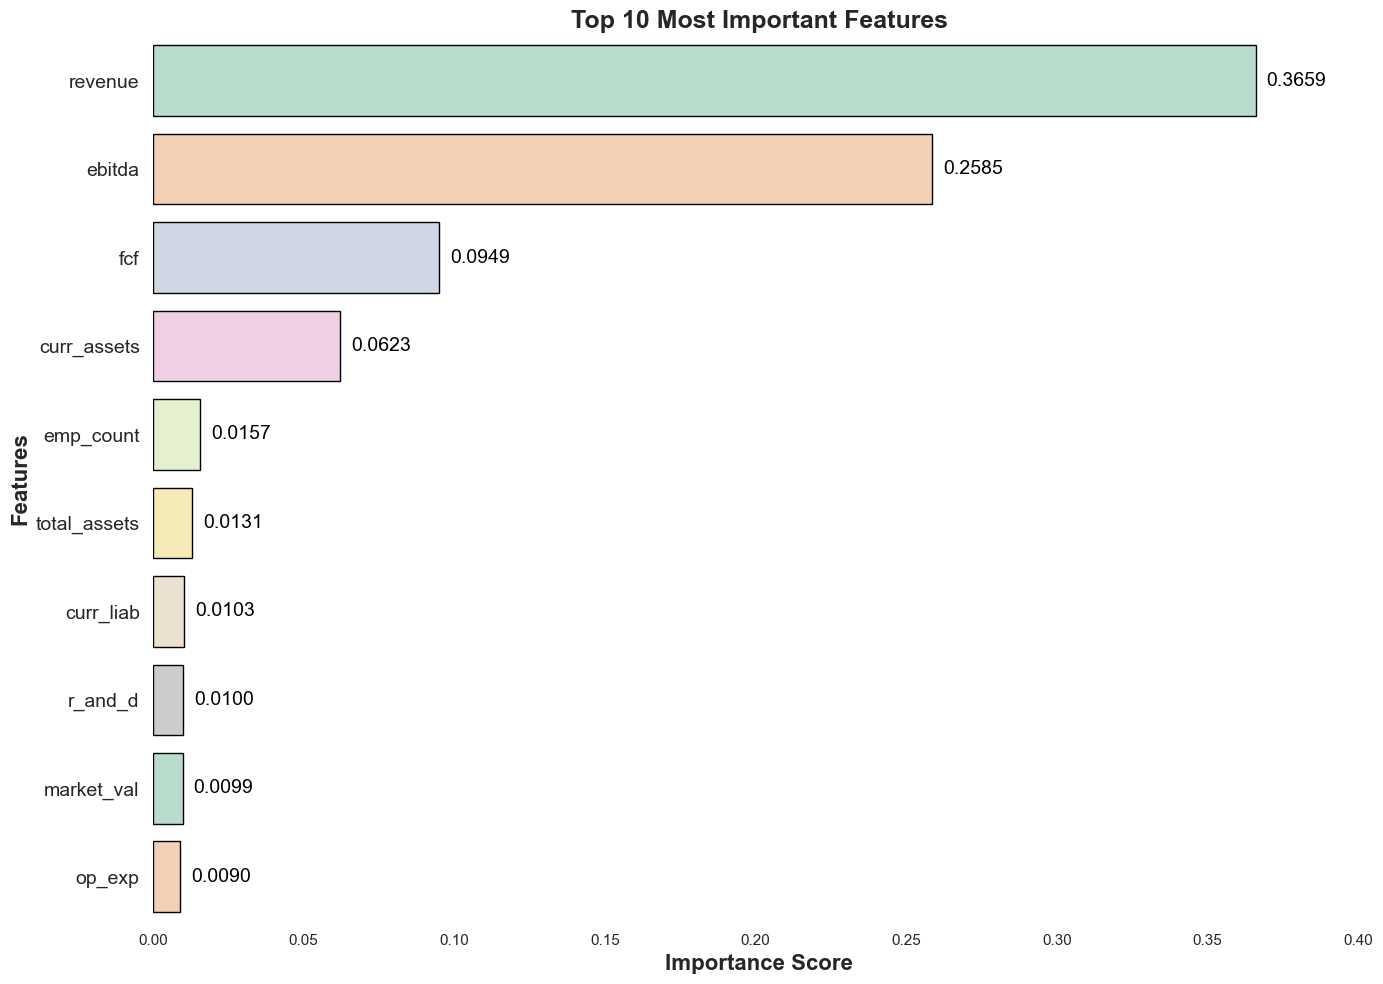

In [15]:
from matplotlib import rc

# 设置全局字体为Times New Roman
rc('font', family='Times New Roman')

top_n = 10
top_features = importance_df.head(top_n)

# 设置 Seaborn 样式为 "white" 以去除网格线
sns.set(style="white")

# 选择一个明亮的颜色调色板，例如 'Set2'
bright_palette = sns.color_palette("Pastel2", top_n)

# 创建图表
plt.figure(figsize=(14, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features,
    palette=bright_palette,
    edgecolor='black'
)

# 添加数值标签
for index, value in enumerate(top_features['Importance']):
    plt.text(
        value + top_features['Importance'].max() * 0.01,  # 在条形末端稍微偏右位置
        index,
        f'{value:.4f}',
        va='center',
        fontsize=14,
        color='black'
    )

# 设置轴标签和标题，增加字体大小和加粗
# 增大特征名称的字号
plt.yticks(fontsize=14, rotation=0)  # 水平条形图中，rotation=0 保持水平
plt.xlabel('Importance Score', fontsize=16, fontweight='bold')
plt.ylabel('Features', fontsize=16, fontweight='bold')
plt.title('Top 10 Most Important Features', fontsize=18, fontweight='bold')

# 移除顶部和右侧的脊线
sns.despine(left=True, bottom=True)

# 调整x轴范围以确保数值标签不被截断
plt.xlim(0, top_features['Importance'].max() * 1.1)

plt.tight_layout()
plt.savefig('feature_importance_top10_EU.png', dpi=400, bbox_inches='tight')
plt.show()


out_R2 = 0.8784
out_EVS = 0.8785
out_MSE = 8772.9595
out_MAE = 31.1736
out_MedAE = 3.6115
out_RMSE = 93.6641


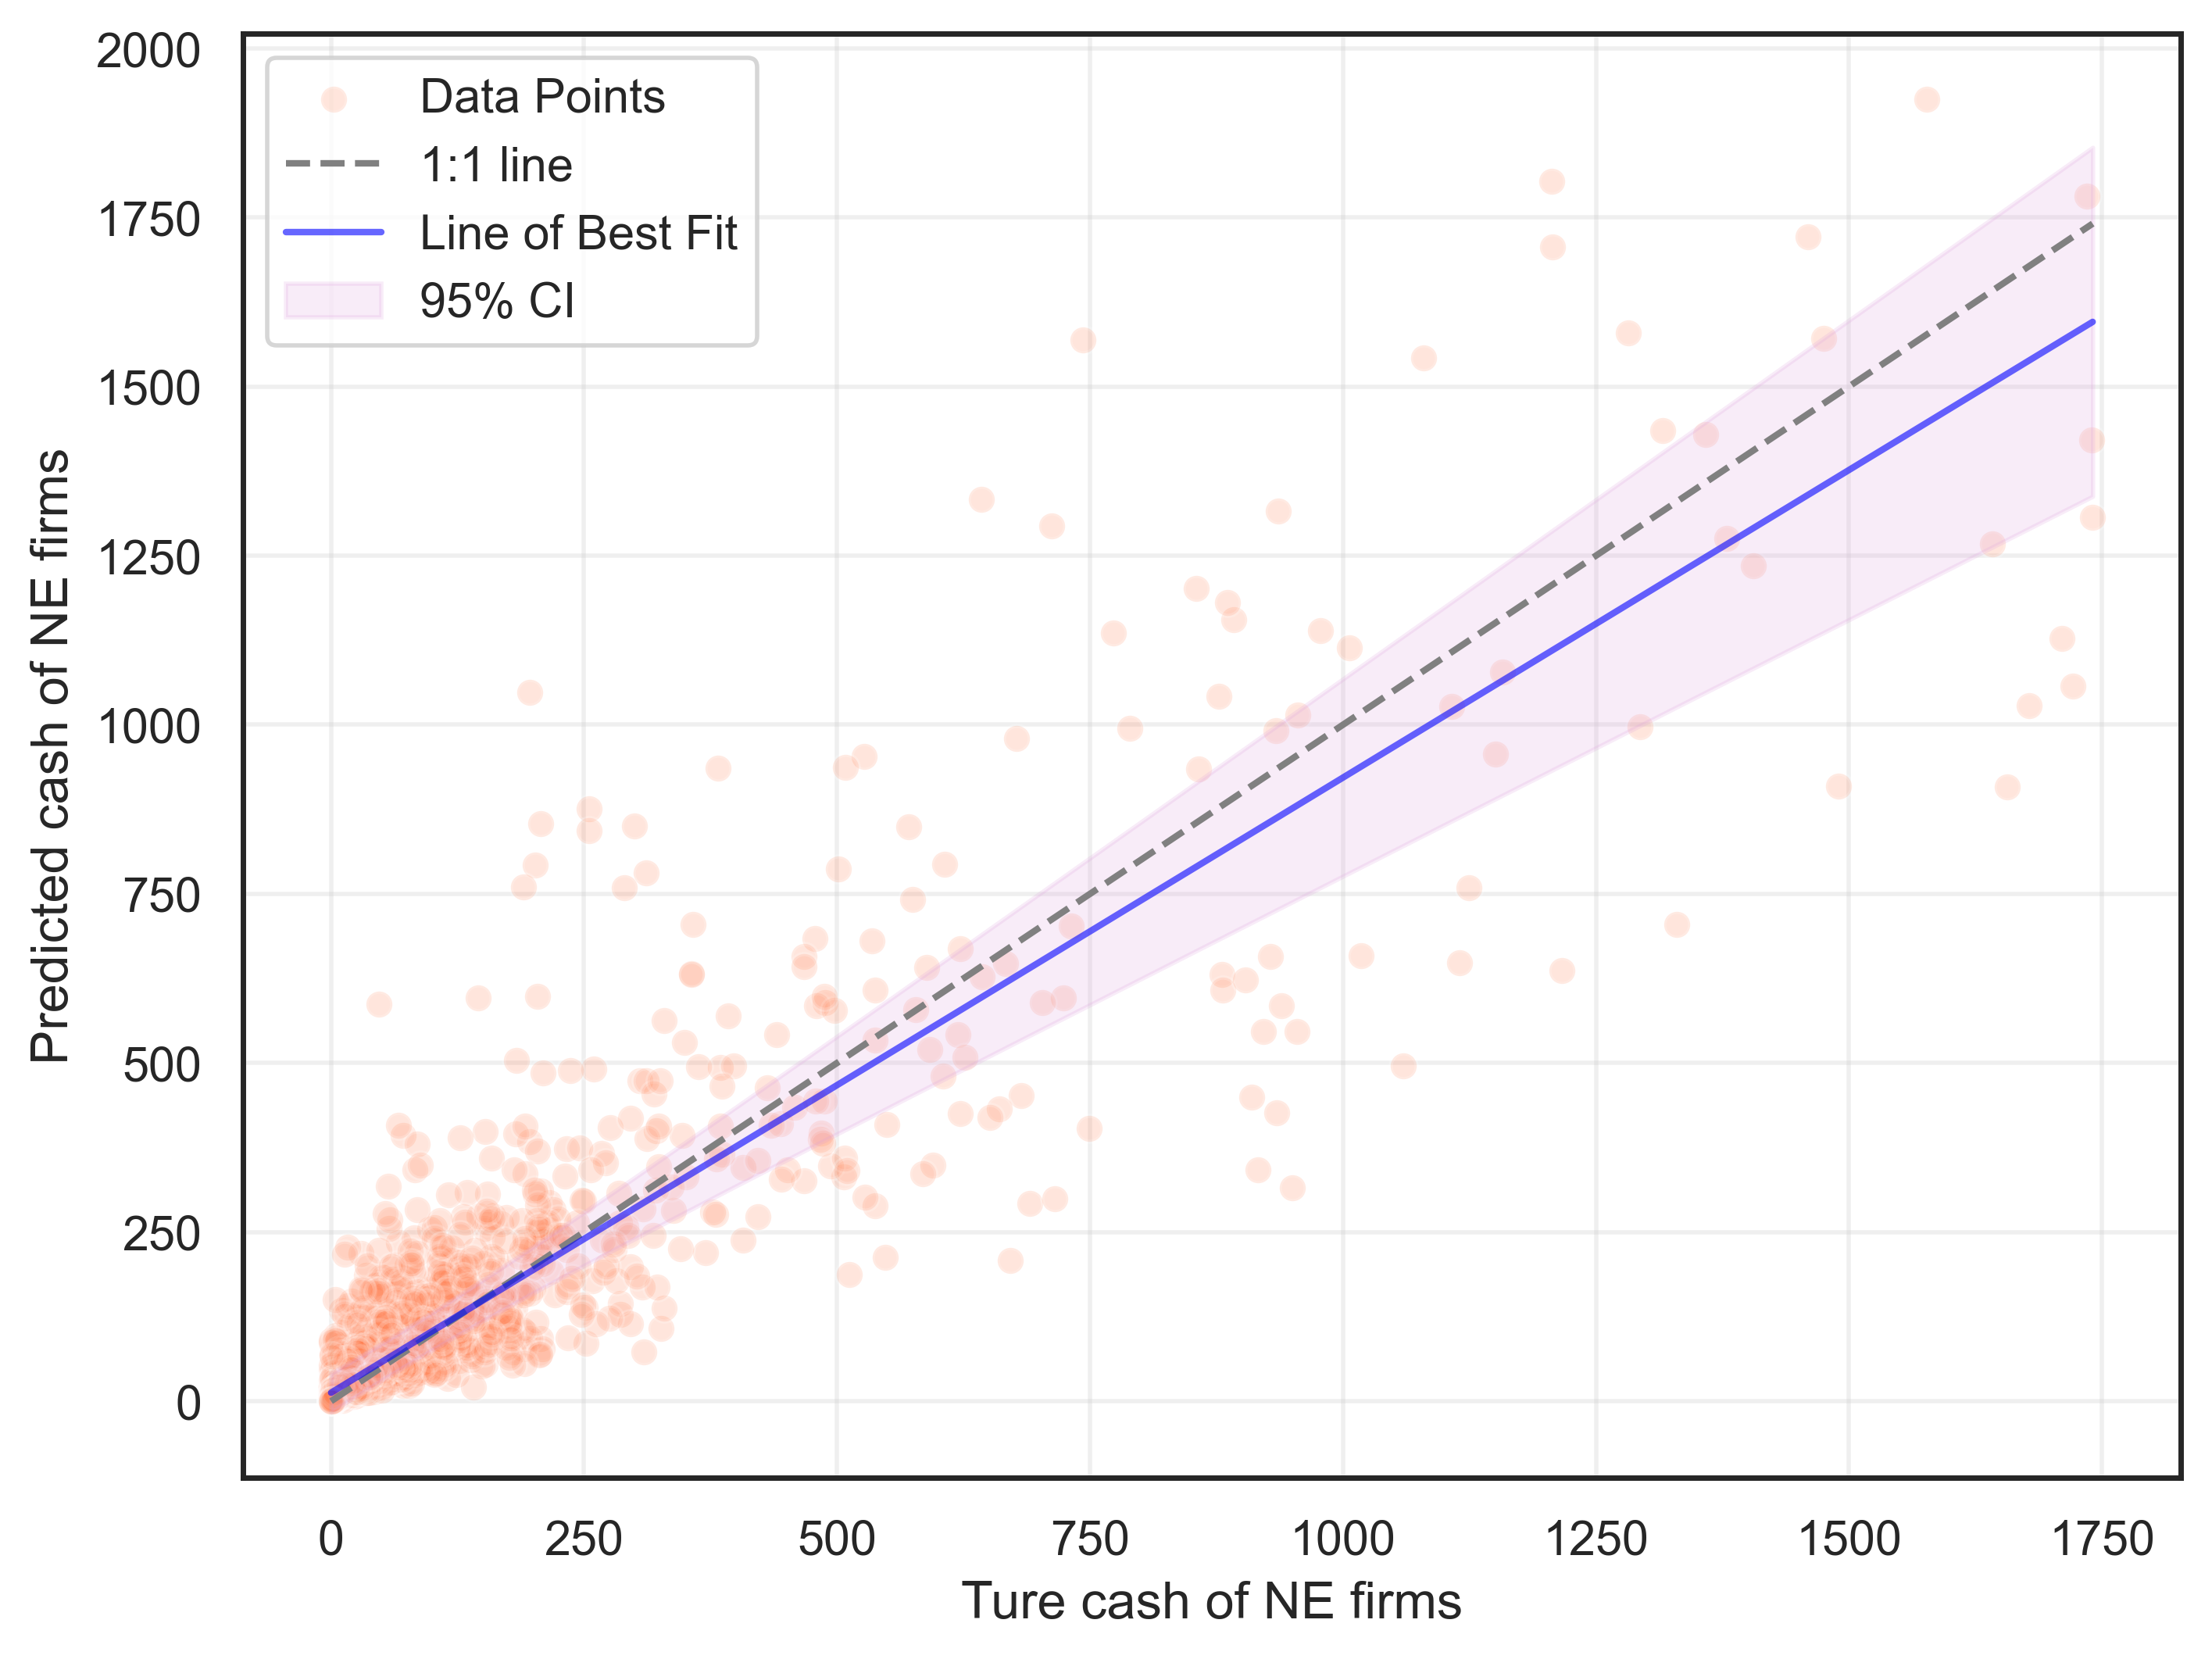

In [16]:
# 样本外预测指标
# 调用 score 函数输出原来的评估结果
score(y_valid, pred_rf_valid)
# 保存图表到本地，设置 dpi 为 400
plt.savefig('rf_model_performance_valid_NorthernEurope2.png', dpi=400, bbox_inches='tight')


# 样本外 R² (Out-of-sample R²)
out_sample_r2 = r2_score(y_valid, pred_rf_valid)
# 计算 EVS (Explained Variance Score)
evs = explained_variance_score(y_valid, pred_rf_valid)
# 计算 MSE (Mean Squared Error)
mse = mean_squared_error(y_valid, pred_rf_valid)
# 计算 MAE (Mean Absolute Error)
mae = mean_absolute_error(y_valid, pred_rf_valid)
# 计算 MedAE (Median Absolute Error)
medae = median_absolute_error(y_valid, pred_rf_valid)
# 计算 RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
# 输出样本外评估指标
print('out_R2 = %.4f' % out_sample_r2)
print('out_EVS = %.4f' % evs)
print('out_MSE = %.4f' % mse)
print('out_MAE = %.4f' % mae)
print('out_MedAE = %.4f' % medae)
print('out_RMSE = %.4f' % rmse)

in_R2 = 0.9827
in_EVS = 0.9827
in_MSE = 1434.4421
in_MAE = 11.8656
in_MedAE = 1.2828
in_RMSE = 37.8740


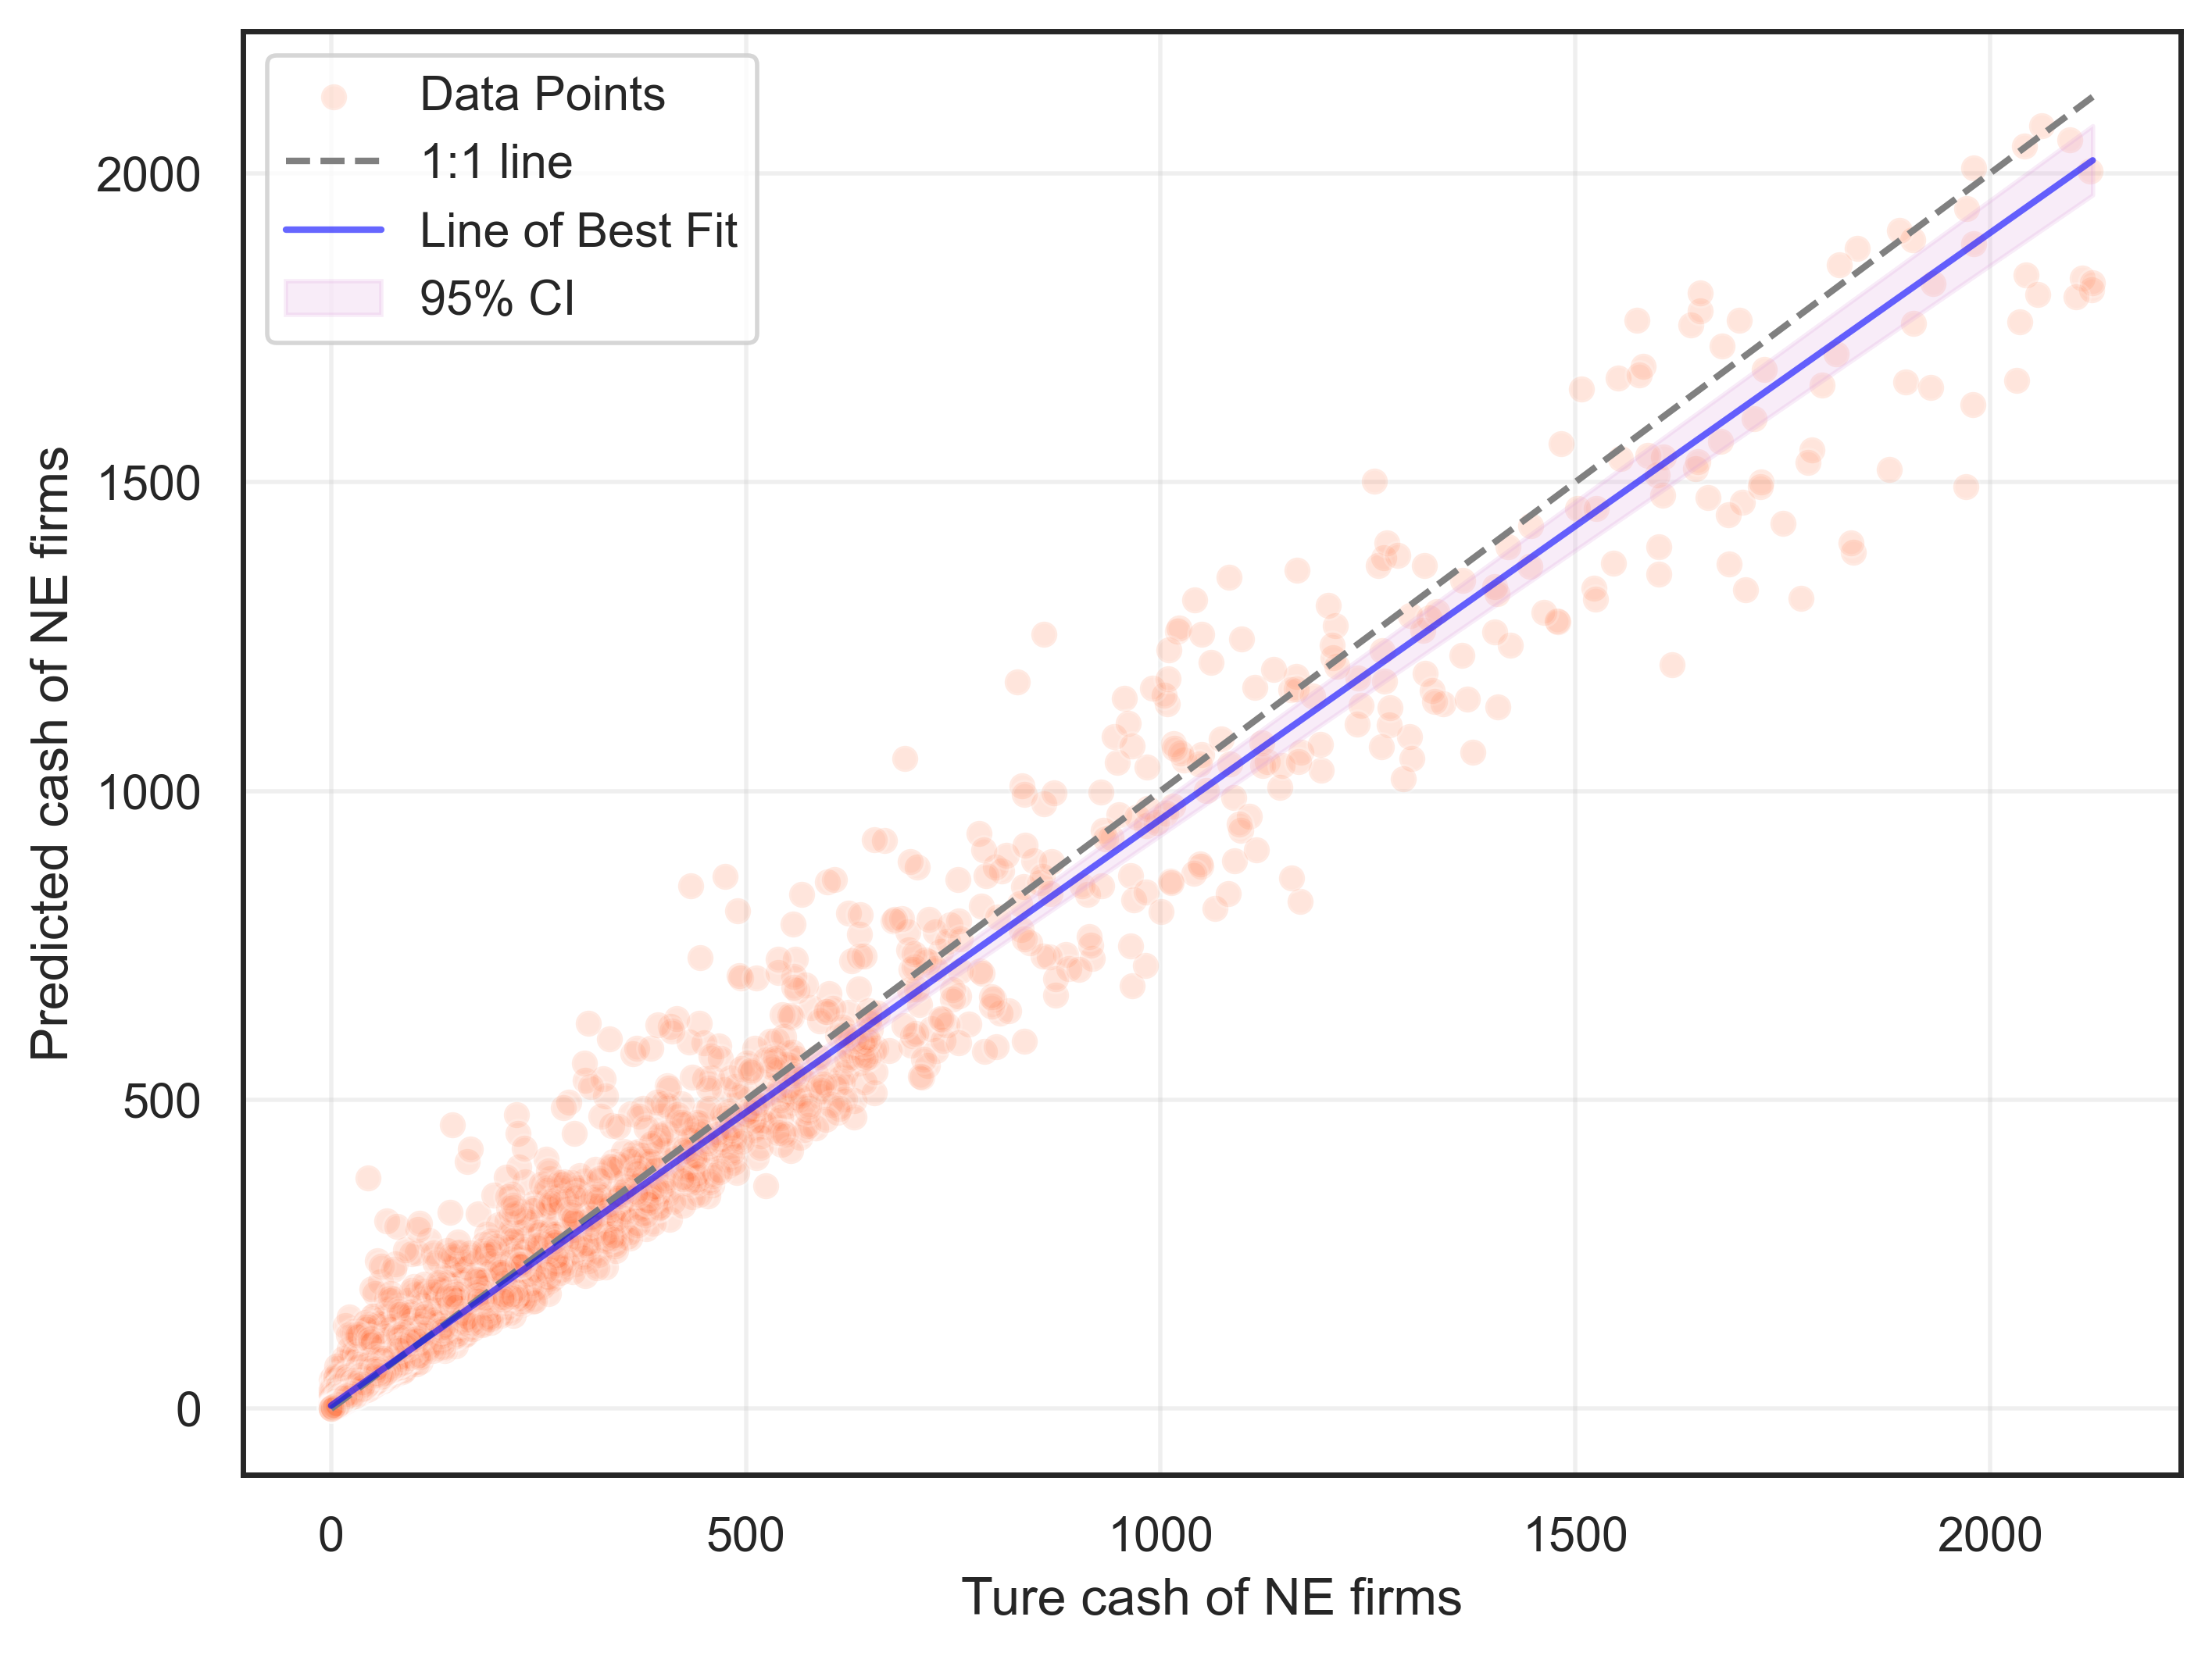

In [17]:
# 样本内预测指标
score(y_train, pred_rf_train)
# 保存图表到本地，设置 dpi 为 400
plt.savefig('rf_model_performance_train_NorthernEurope2.png', dpi=400, bbox_inches='tight')

# 样本内 R² (Training R²)
sample_in_r2 = r2_score(y_train, pred_rf_train)
# 计算 EVS (Explained Variance Score)
evs_train = explained_variance_score(y_train, pred_rf_train)
# 计算 MSE (Mean Squared Error)
mse_train = mean_squared_error(y_train, pred_rf_train)
# 计算 MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_train, pred_rf_train)
# 计算 MedAE (Median Absolute Error)
medae_train = median_absolute_error(y_train, pred_rf_train)
# 计算 RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mse_train)
# 输出样本内评估指标
print('in_R2 = %.4f' % sample_in_r2)
print('in_EVS = %.4f' % evs_train)
print('in_MSE = %.4f' % mse_train)
print('in_MAE = %.4f' % mae_train)
print('in_MedAE = %.4f' % medae_train)
print('in_RMSE = %.4f' % rmse_train)

In [20]:
# 提取特征和目标变量
dtest1 = data[data["country"] != 4]
dtest1 = dtest1.dropna()
dtest1 = winsorize_data(dtest1)

# 预测所需特征
X_test1 = dtest1.drop(columns=['comp_id', 'country', 'country_short', 'cash'])

# 将特征转化为 NumPy 数组
X_test1 = np.array(X_test1)

# 使用训练好的模型对 X_test1 进行预测
y_pred_dtest1 = rf_model.predict(X_test1)

# 将预测结果作为新的一列添加到 dtest1 中
dtest1['predicted_y1'] = y_pred_dtest1

# 只保留指定的列
columns_to_keep = ['comp_id', 'year', 'country_short', 'cash', 'total_assets', 'mkt_cap', 'sic', 'predicted_y1']
dtest1 = dtest1[columns_to_keep]

# 保存结果到本地 CSV 文件
dtest1.to_csv('dtest_all_predictions_NE.csv', index=False)

# 查看包含预测结果的 dtest1
print(dtest1.head())


    comp_id  year country_short   cash  total_assets  mkt_cap  sic  \
1  IQ100013  1998           THA  1.600     1975.4509    550.0   20   
2  IQ100013  1999           THA  1.050     2414.8796    550.0   20   
3  IQ100013  2000           THA  0.329     2346.3507    220.0   20   
4  IQ100013  2001           THA  0.304     2041.6563    180.0   20   
5  IQ100013  2002           THA  0.204     2043.5286    167.0   20   

   predicted_y1  
1     24.669491  
2     38.717260  
3     35.097937  
4     26.985112  
5     36.006187  


In [ ]:
'''#2=India
# 提取特征和目标变量
dtest2 = data[data["country"] == 2]
dtest2 = dtest2.dropna()
dtest2 = winsorize_data(dtest2)

X_test2 = dtest2.drop(columns=['comp_id', 'country', 'cash'])

#标准化特征变量
#sc = StandardScaler()
#sc.fit(X_test2)
#X_test2 = sc.transform(X_test2)
X_test2 = np.array(X_test2)

# 使用训练好的模型对X_test进行预测
y_pred_dtest2 = rf_model.predict(X_test2)

# 将预测结果作为新的一列添加到 dtest 中
dtest2['predicted_y2'] = y_pred_dtest2

# 保存带有预测结果的数据到本地 CSV 文件
dtest2.to_csv('dtest_India_predictions_NE.csv', index=False)

# 查看包含预测结果的 dtest
print(dtest2.head())  

In [ ]:
'''#3=China
# 提取特征和目标变量
dtest3 = data[data["country"] == 3]
dtest3 = dtest3.dropna()
dtest3 = winsorize_data(dtest3)

X_test3 = dtest3.drop(columns=['comp_id', 'country', 'cash'])

#标准化特征变量
#sc = StandardScaler()
#sc.fit(X_test3)
#X_test3 = sc.transform(X_test3)
X_test3 = np.array(X_test3)

# 使用训练好的模型对X_test进行预测
y_pred_dtest3 = rf_model.predict(X_test3)

# 将预测结果作为新的一列添加到 dtest 中
dtest3['predicted_y3'] = y_pred_dtest3

# 保存带有预测结果的数据到本地 CSV 文件
dtest3.to_csv('dtest_China_predictions_NE.csv', index=False)

# 查看包含预测结果的 dtest
print(dtest3.head())  

In [15]:
'''#5=USA
# 提取特征和目标变量
dtest5 = data[data["country"] == 5]
dtest5 = dtest5.dropna()
dtest5 = winsorize_data(dtest5)

X_test5 = dtest5.drop(columns=['comp_id', 'country', 'cash'])

#标准化特征变量
#sc = StandardScaler()
#sc.fit(X_test5)
#X_test5 = sc.transform(X_test5)
X_test5 = np.array(X_test5)

# 使用训练好的模型对X_test进行预测
y_pred_dtest5 = rf_model.predict(X_test5)

# 将预测结果作为新的一列添加到 dtest 中
dtest5['predicted_y5'] = y_pred_dtest5

# 保存带有预测结果的数据到本地 CSV 文件
dtest5.to_csv('dtest_USA_predictions_NE.csv', index=False)

# 查看包含预测结果的 dtest
print(dtest5.head())  

      comp_id  year  revenue  total_assets  r_and_d  ebitda  st_invest  \
0  IQ10004497  2002     92.7       213.594      0.0    30.1        0.0   
1  IQ10004497  2003     99.7       243.644      0.0    21.0        0.0   
3  IQ10004497  2005    113.8       225.784      0.0    23.4        0.0   
4  IQ10004497  2006    114.6       220.816      0.0    19.9        0.0   
5  IQ10004497  2013    193.3       293.607      0.0    46.3        0.0   

     cash  tmax_pos        srad  ...     leverage  market_val  sic  \
0   0.805         3  160.979904  ...   656.388000  159.695007   21   
1   0.304         0  162.475418  ...  1037.033325  191.682007   21   
3   0.525         1  167.155182  ...  -342.069275  262.670013   21   
4   1.800         3  169.881104  ...  -306.279602  269.186981   21   
5  35.400         0  165.314285  ...  -473.821716  265.164001   21   

            GDP     GDP_pc  GDP_growth  inflation  inst_own  public_own  \
0  1.408425e+13  48967.366       1.700      1.554   1.10342